Script to generate Fig 7:
- Acceleration of the ASC and CC under enhanced meltwater forcing is illustrated by upper 500 m
depth mean speed anomalies (with respect to the control simulation) averaged over the final year of the MW45
(a) and MW85 (b) simulations. The 1000 m isobath is delineated by black contours. (c-f) Full depth integrated
westward transport across four cross-slope transects in Queen Maud Land (c), the Ad´elie Coast (d), Marie Byrd
Land (e), and the Antarctic Peninsula (f). Transect locations are indicated by thick black lines and numbering in
(a). Annual mean flow rates for the final year of the experimental period are shown, with dashed lines indicating
where the transect intersects with the 1000 m isobath, a boundary used here to partition flow associated with
the CC (peak poleward of isobath) from flow associated with the ASC (peak north of isobath). The coastline
and 1000 m isobath coincide at the Queen Maud Land transect (c), so all westward transport is attributed to the
ASC. Inset values are the total westward transport of the CC (below dashed line) and ASC (above dashed line)
across the transects, computed by integrating plotted values from the coastline the the 1000 m isobath for CC
transports, and from the 1000 m isobath (or coastline, in (c)) to the point where the net zonal transport switches
from westward to eastward (crossing the 0 transport line shown). Note negative values indicate eastward CC
transport and there is no ASC flow (which is exclusively defined as westward flow) across the Antarctic Peninsula
transect in the control simulation (f).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as col
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import matplotlib.path as mpath
### establish link to python functions
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
### import required python functions
from masking import shelf_mask_isobath, fill_land
from spatial_averaging import month_weights
import cosima_cookbook as cc
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


In [2]:
db = '/g/data/v45/rm2389/databases/freshwater_experiments.db' # database path
session = cc.database.create_session(db)
control='01deg_jra55v13_ryf8485_spinup6'
rcp45='01deg_jra55v13_ryf8485_freshRCP45'
rcp85='01deg_jra55v13_ryf8485_freshRCP85'

In [19]:
from matplotlib import rc, rcParams
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

### Speed anomaly maps

In [13]:
## upper 500m mean speed anomalies
control_speed = xr.open_dataset('/g/data/v45/rm2389/Speed_Transport/control_upper_500m_speed.nc')
rcp45_speed = xr.open_dataset('/g/data/v45/rm2389/Speed_Transport/rcp45_upper_500m_speed.nc')
rcp85_speed = xr.open_dataset('/g/data/v45/rm2389/Speed_Transport/rcp85_upper_500m_speed.nc')
control_speed = control_speed.upper_500m_speed
rcp45_speed = rcp45_speed.upper_500m_speed
rcp85_speed = rcp85_speed.upper_500m_speed
timeslice = slice('1937-06','1947-05')
control_speed = control_speed.sel(time = timeslice)
rcp45_speed = rcp45_speed.sel(time = timeslice)
rcp85_speed = rcp85_speed.sel(time = timeslice)
rcp45_speed_anom = rcp45_speed - control_speed
rcp85_speed_anom = rcp85_speed - control_speed
time = control_speed.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=10), coords = [time], dims = 'time')
rcp45_speed_anom_mean = (rcp45_speed_anom*weights).mean(dim = 'time')
rcp85_speed_anom_mean = (rcp85_speed_anom*weights).mean(dim = 'time')

In [16]:
rcp45_speed_anom_mean = rcp45_speed_anom_mean.sel(yu_ocean = slice(-90,-59))
rcp85_speed_anom_mean = rcp85_speed_anom_mean.sel(yu_ocean = slice(-90,-59))

In [24]:
def speed_anomaly_polar(ax0, ax1, mcmap):
    norm1 = col.Normalize(vmin=-0.15,vmax=0.15) 
    fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    ## rcp45 anomaly
    anomaly = ax0.pcolormesh(rcp45_speed_anom_mean.xu_ocean,rcp45_speed_anom_mean.yu_ocean,rcp45_speed_anom_mean,cmap=mcmap,norm=norm1,transform=ccrs.PlateCarree())
    ax0.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax0.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', linewidth = 1, transform=ccrs.PlateCarree())
    antarctic_map(ax0,1,True,-59)
    ax1.pcolormesh(rcp85_speed_anom_mean.xu_ocean,rcp85_speed_anom_mean.yu_ocean,rcp85_speed_anom_mean,cmap=mcmap,norm=norm1,transform=ccrs.PlateCarree())   
    ax1.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax1.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', linewidth = 1, transform=ccrs.PlateCarree())
    antarctic_map(ax1,1,True,-59)

    
    ax1.plot([-64,-64],[-65, -62], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax0.plot([-64,-64],[-65, -62], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax1.plot([-216,-216],[-67.1, -64.6], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax1.plot([-145,-145],[-75.4, -72.3], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax1.plot([20,20],[-69.8, -67], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax0.plot([-216,-216],[-67.1, -64.6], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax0.plot([-145,-145],[-75.4, -72.3], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    ax0.plot([20,20],[-69.8, -67], color = 'k', linewidth = 4, transform=ccrs.PlateCarree())
    
    return anomaly

In [22]:
ht = cc.querying.getvar(control,'ht',session, n=1) 
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

In [25]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
def antarctic_map(ax, isobath_linewidth, grid, north, isobath_colour = 'k'):
    ax.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = isobath_colour, linewidth = isobath_linewidth, transform=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, north], ccrs.PlateCarree())
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--')
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50])

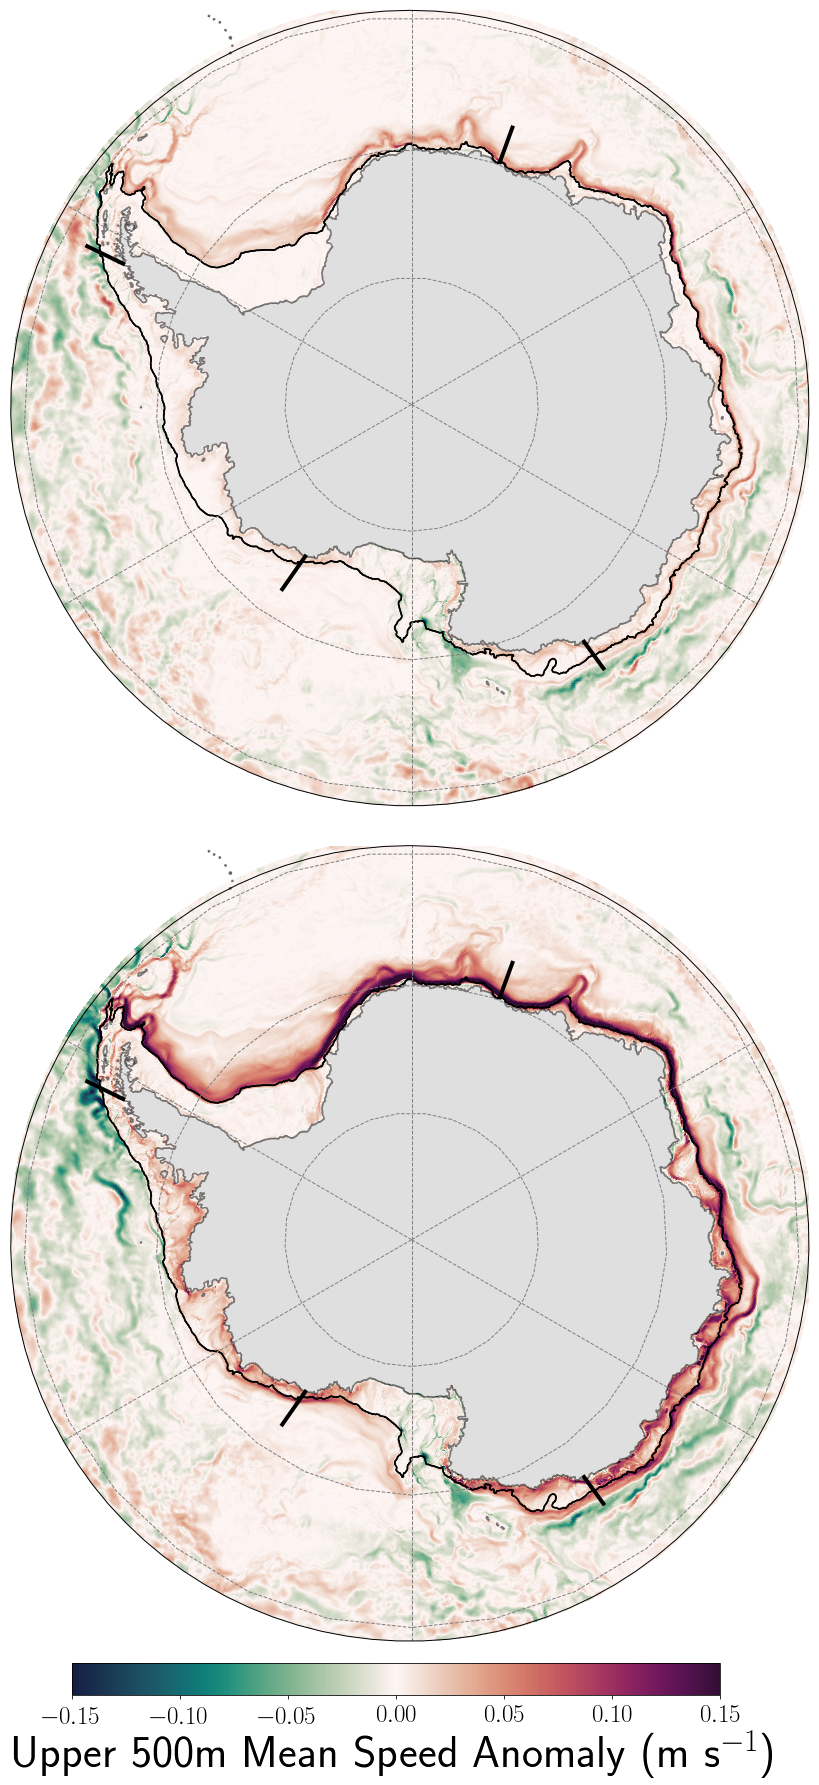

In [29]:
fig = plt.figure(1,figsize = (15,30))
gs = gridspec.GridSpec(2,1)
gs.update(hspace = 0.05)

ax0, ax1= plt.subplot(gs[0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1],projection=ccrs.SouthPolarStereo())
speed = speed_anomaly_polar(ax0,ax1,cmo.curl)

cax = fig.add_axes([0.2, 0.1, 0.6, 0.015])
cbar=plt.colorbar(speed,cax = cax,orientation='horizontal',shrink = 0.5)
cbar.set_label(r'Upper 500m Mean Speed Anomaly (m s$^{-1}$)', fontsize = 45)

figurepath = 'Fig7ab.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='png',
                transparent=False, bbox_inches='tight', pad_inches=0.1,
                frameon=None)
plt.show()

### Transport anomalies across transects

In [30]:
full_tx_trans_control = xr.open_dataset('/g/data/v45/rm2389/ASC_Transects/depth_integrated_ASC_transport/control_full_tx_trans.nc')
full_tx_trans_rcp45 = xr.open_dataset('/g/data/v45/rm2389/ASC_Transects/depth_integrated_ASC_transport/rcp45_full_tx_trans.nc')
full_tx_trans_rcp85 = xr.open_dataset('/g/data/v45/rm2389/ASC_Transects/depth_integrated_ASC_transport/rcp85_full_tx_trans.nc')
full_tx_trans_control = full_tx_trans_control.full_tx_trans
full_tx_trans_rcp45 = full_tx_trans_rcp45.full_tx_trans
full_tx_trans_rcp85 = full_tx_trans_rcp85.full_tx_trans

In [31]:
full_tx_trans_control_end = full_tx_trans_control.sel(time = slice('1946-06','1947-05'))
full_tx_trans_rcp45_end = full_tx_trans_rcp45.sel(time = slice('1946-06','1947-05'))
full_tx_trans_rcp85_end = full_tx_trans_rcp85.sel(time = slice('1946-06','1947-05'))
time = full_tx_trans_rcp85_end.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
full_tx_trans_control_end = (full_tx_trans_control_end * weights).mean(dim = 'time')
full_tx_trans_rcp45_end = (full_tx_trans_rcp45_end * weights).mean(dim = 'time')
full_tx_trans_rcp85_end = (full_tx_trans_rcp85_end * weights).mean(dim = 'time')

In [32]:
ht_full = cc.querying.getvar(control,'ht',session, n=1) 
yt_ocean_full = ht_full.yt_ocean
xt_ocean_full = ht_full.xt_ocean

In [34]:
dyt = cc.querying.getvar(control,'dyt',session, ncfile = 'ocean_grid.nc', n=1) 
dyt.coords['xt_ocean'] = full_tx_trans_control_end.xu_ocean.values
dyt = dyt.rename({'xt_ocean':'xu_ocean'})
full_trans_control_end = full_tx_trans_control_end/dyt
full_trans_rcp45_end = full_tx_trans_rcp45_end/dyt
full_trans_rcp85_end = full_tx_trans_rcp85_end/dyt

In [35]:
adelie_control_end = full_trans_control_end.sel(xu_ocean = -216, method = 'nearest')
adelie_rcp45_end = full_trans_rcp45_end.sel(xu_ocean = -216, method = 'nearest')
adelie_rcp85_end = full_trans_rcp85_end.sel(xu_ocean = -216, method = 'nearest')
amundsen_control_end = full_trans_control_end.sel(xu_ocean = -145, method = 'nearest')
amundsen_rcp45_end = full_trans_rcp45_end.sel(xu_ocean = -145, method = 'nearest')
amundsen_rcp85_end = full_trans_rcp85_end.sel(xu_ocean = -145, method = 'nearest')
east_control_end = full_trans_control_end.sel(xu_ocean = 20, method = 'nearest')
east_rcp45_end = full_trans_rcp45_end.sel(xu_ocean = 20, method = 'nearest')
east_rcp85_end = full_trans_rcp85_end.sel(xu_ocean = 20, method = 'nearest')
wap_control_end = full_trans_control_end.sel(xu_ocean = -64, method = 'nearest')
wap_rcp45_end = full_trans_rcp45_end.sel(xu_ocean = -64, method = 'nearest')
wap_rcp85_end = full_trans_rcp85_end.sel(xu_ocean = -64, method = 'nearest')

In [36]:
adelie_control_end = adelie_control_end * 1e4
adelie_rcp45_end = adelie_rcp45_end * 1e4
adelie_rcp85_end = adelie_rcp85_end * 1e4
amundsen_control_end = amundsen_control_end * 1e4
amundsen_rcp45_end = amundsen_rcp45_end * 1e4
amundsen_rcp85_end = amundsen_rcp85_end * 1e4
east_control_end = east_control_end * 1e4
east_rcp45_end = east_rcp45_end * 1e4
east_rcp85_end = east_rcp85_end * 1e4
wap_control_end = wap_control_end * 1e4
wap_rcp45_end = wap_rcp45_end * 1e4
wap_rcp85_end = wap_rcp85_end * 1e4

In [37]:
import matplotlib.cm as cm
cmap = cm.get_cmap('Oranges')
orange_color = cmap(0.75)

In [61]:
def flow_structures(ax0, ax1,ax2, ax3):
    ## adelie
    ax1.plot(-adelie_control_end,adelie_control_end.yt_ocean,'k', linewidth = 2)
    ax1.plot(-adelie_rcp45_end,adelie_rcp45_end.yt_ocean,color = 'mediumblue', linewidth = 2)
    ax1.plot(-adelie_rcp85_end,adelie_rcp85_end.yt_ocean,color = orange_color, linewidth = 2)
    ax1.plot( [0,0], [-67.1,-62.65],'k', alpha = 0.3)
    ax1.plot( [-1,3.5], [-66,-66],'k--', alpha = 0.6)
    ax1.set_ylim([-67.1, -64.5])
    ax1.set_xlim([-1,3.5])
    ax1.set_xticks([-1,0,1,2,3])
    
    ## amundsen
    ax2.plot(-amundsen_control_end,amundsen_control_end.yt_ocean,'k', linewidth = 2, label = 'Control')
    ax2.plot(-amundsen_rcp45_end,amundsen_rcp45_end.yt_ocean,color = 'mediumblue', linewidth = 2, label = 'RCP4.5')
    ax2.plot(-amundsen_rcp85_end,amundsen_rcp85_end.yt_ocean,color = orange_color, linewidth = 2, label = 'RCP8.5')
    ax2.plot( [0,0], [-75.4,-72.3],'k', alpha = 0.3)
    ax2.plot( [-0.5,4], [-74.67, -74.67],'k--', alpha = 0.6)
    ax2.set_ylim([-75.4, -72.3])
    ax2.set_xlim([-0.5,4])
    ax2.set_xticks([0,1,2,3,4])
    ax2.set_xlabel(r'Westward Transport ($\times 10^{-4}$ Sv m$^{-1}$)', fontsize = 30)
    ax2.set_ylabel('Latitude ($^\circ$N)', fontsize = 40)
    
    ## east antarctica
    ax0.plot(-east_control_end,east_control_end.yt_ocean,'k', linewidth = 2)
    ax0.plot(-east_rcp45_end,east_rcp45_end.yt_ocean,color = 'mediumblue', linewidth = 2)
    ax0.plot(-east_rcp85_end,east_rcp85_end.yt_ocean,color = orange_color, linewidth = 2)
    ax0.plot( [0,0], [-69.8,67],'k', alpha = 0.3)
    ax0.set_ylim([-69.75,-67])
    ax0.set_xlim([-0.5,6])
    ax0.set_xticks([0,1,2,3,4,5,6])
    ax0.set_ylabel('Latitude ($^\circ$N)', fontsize = 40)

    ## east antarctica
    ax3.plot(-wap_control_end,wap_control_end.yt_ocean,'k', linewidth = 2)
    ax3.plot(-wap_rcp45_end,wap_rcp45_end.yt_ocean,color = 'mediumblue', linewidth = 2)
    ax3.plot(-wap_rcp85_end,wap_rcp85_end.yt_ocean,color = orange_color, linewidth = 2)
    ax3.plot( [0,0], [-65,-62],'k', alpha = 0.3)
    ax3.set_ylim([-64.5, -62])
    ax3.plot( [-3,3], [-63.1, -63.1],'k--', alpha = 0.6)
    ax3.set_xlim([-3,3])
    ax3.set_xticks([-3,-2, -1, 0, 1 ,2,3])
    ax3.set_xlabel(r'Westward Transport ($\times 10^{-4}$ Sv m$^{-1}$)', fontsize = 30)

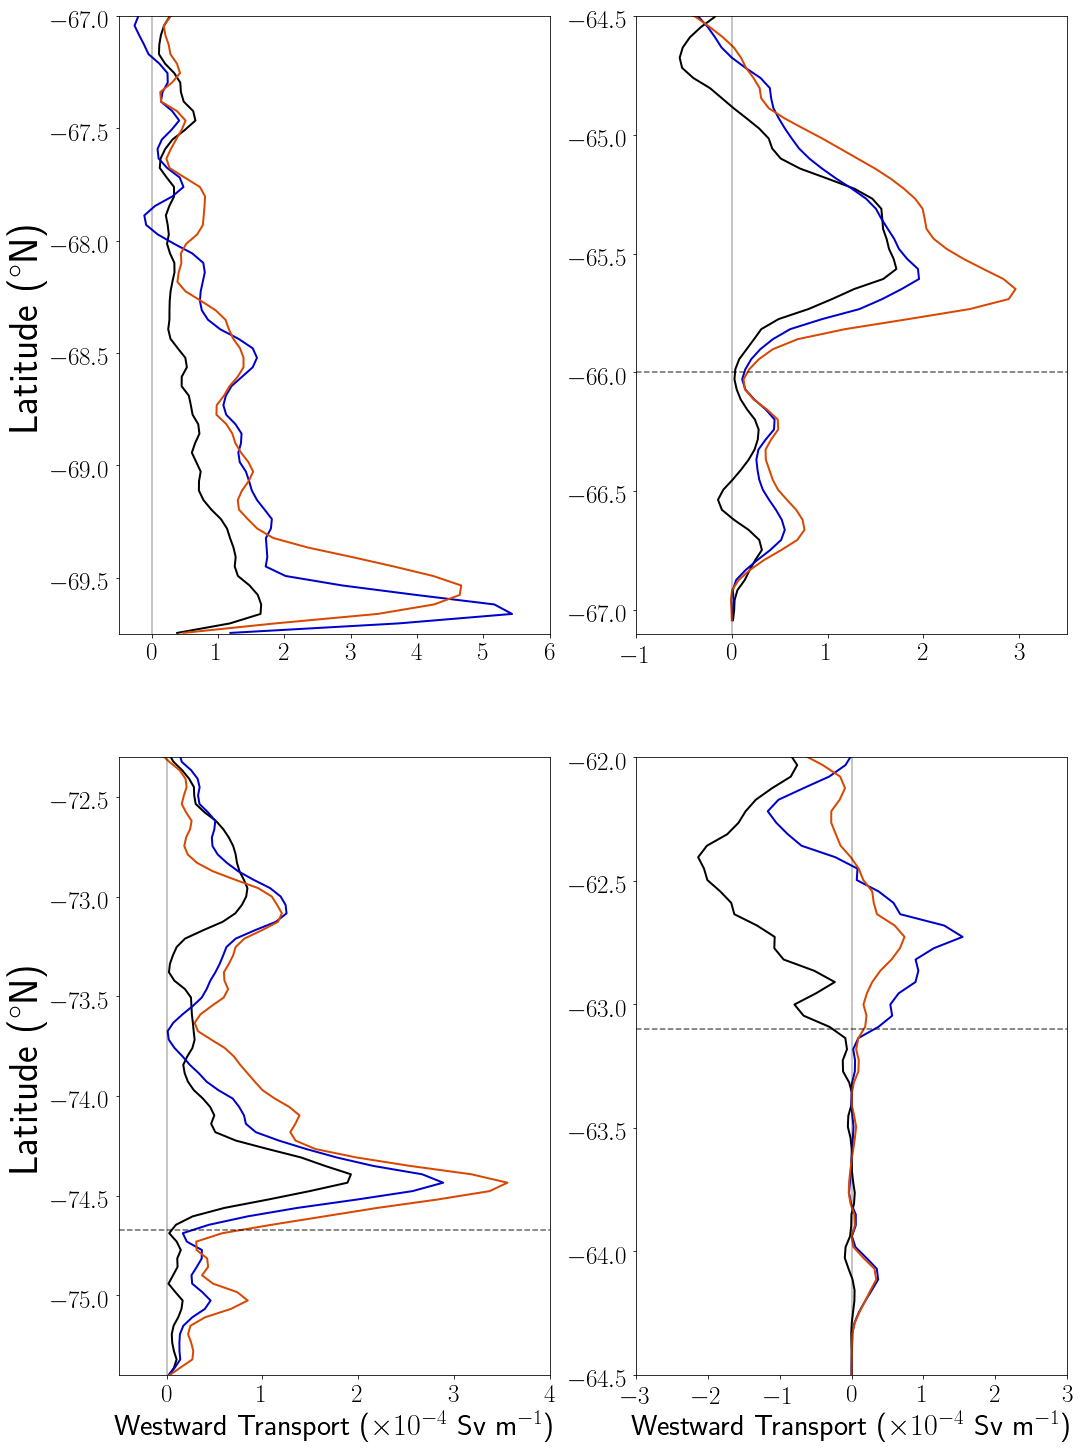

In [63]:
fig=plt.figure(2,(17,25))
gs = gridspec.GridSpec(2,2)
gs.update(hspace = 0.2,wspace = 0.2)

ax0, ax1, ax2, ax3 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,0]), plt.subplot(gs[1,1])

flow_structures(ax0, ax1, ax2, ax3)

figurepath = 'Fig7cf.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format='png',
                transparent=False, bbox_inches='tight', pad_inches=0.1,
                frameon=None)
plt.show()

In [64]:
## for the inset values
# when commuting summed average, dont want the one multiplied by dyt
adelie_control_end = full_tx_trans_control_end.sel(xu_ocean = -216, method = 'nearest')
adelie_rcp45_end = full_tx_trans_rcp45_end.sel(xu_ocean = -216, method = 'nearest')
adelie_rcp85_end = full_tx_trans_rcp85_end.sel(xu_ocean = -216, method = 'nearest')
amundsen_control_end = full_tx_trans_control_end.sel(xu_ocean = -145, method = 'nearest')
amundsen_rcp45_end = full_tx_trans_rcp45_end.sel(xu_ocean = -145, method = 'nearest')
amundsen_rcp85_end = full_tx_trans_rcp85_end.sel(xu_ocean = -145, method = 'nearest')
east_control_end = full_tx_trans_control_end.sel(xu_ocean = 20, method = 'nearest')
east_rcp45_end = full_tx_trans_rcp45_end.sel(xu_ocean = 20, method = 'nearest')
east_rcp85_end = full_tx_trans_rcp85_end.sel(xu_ocean = 20, method = 'nearest')
wap_control_end = full_tx_trans_control_end.sel(xu_ocean = -64, method = 'nearest')
wap_rcp45_end = full_tx_trans_rcp45_end.sel(xu_ocean = -64, method = 'nearest')
wap_rcp85_end = full_tx_trans_rcp85_end.sel(xu_ocean = -64, method = 'nearest')

In [65]:
print('Adelie ACC control:',(adelie_control_end.sel(yt_ocean = slice(-67,-66)).sum('yt_ocean')).values)
print('Adelie ACC rcp45:',(adelie_rcp45_end.sel(yt_ocean = slice(-67,-66)).sum('yt_ocean')).values)
print('Adelie ACC rcp85:',(adelie_rcp85_end.sel(yt_ocean = slice(-67,-66)).sum('yt_ocean')).values)
print(' ')
print('Adelie ASC control:',(adelie_control_end.sel(yt_ocean = slice(-66,-64.6)).sum('yt_ocean')).values)
print('Adelie ASC rcp45:',(adelie_rcp45_end.sel(yt_ocean = slice(-66,-64.6)).sum('yt_ocean')).values)
print('Adelie ASC rcp85:',(adelie_rcp85_end.sel(yt_ocean = slice(-66,-64.6)).sum('yt_ocean')).values)

Adelie ACC control: -1.2906637787054236
Adelie ACC rcp45: -3.1967179713100964
Adelie ACC rcp85: -4.114727633014403
 
Adelie ASC control: -9.983524718155211
Adelie ASC rcp45: -14.370534155298381
Adelie ASC rcp85: -20.766503457928536


In [66]:
print('Amundsen ACC control:',(amundsen_control_end.sel(yt_ocean = slice(-75.4,-74.67)).sum('yt_ocean')).values)
print('Amundsen ACC rcp45:',(amundsen_rcp45_end.sel(yt_ocean = slice(-75.4,-74.67)).sum('yt_ocean')).values)
print('Amundsen ACC rcp85:',(amundsen_rcp85_end.sel(yt_ocean = slice(-75.4,-74.67)).sum('yt_ocean')).values)
print(' ')
print('Amundsen ASC control:',(amundsen_control_end.sel(yt_ocean = slice(-74.67,-72.3)).sum('yt_ocean')).values)
print('Amundsen ASC rcp45:',(amundsen_rcp45_end.sel(yt_ocean = slice(-74.67,-72.3)).sum('yt_ocean')).values)
print('Amundsen ASC rcp85:',(amundsen_rcp85_end.sel(yt_ocean = slice(-74.67,-72.3)).sum('yt_ocean')).values)

Amundsen ACC control: -0.7443023545134589
Amundsen ACC rcp45: -2.0088262284799696
Amundsen ACC rcp85: -3.2870624076683486
 
Amundsen ASC control: -13.883225310185537
Amundsen ASC rcp45: -20.53934054847118
Amundsen ASC rcp85: -25.429836940716584


In [67]:
print('Queen Maud ASC control new:',(east_control_end.sel(yt_ocean = slice(-69.8, -63.1)).sum('yt_ocean')).values)
print('Queen Maud ASC rcp45 new:',(east_rcp45_end.sel(yt_ocean = slice(-69.8, -63.1)).sum('yt_ocean')).values)
print('Queen Maud ASC rcp85 new:',(east_rcp85_end.sel(yt_ocean = slice(-69.8, -63.1)).sum('yt_ocean')).values)

Queen Maud ASC control new: -42.32916138015929
Queen Maud ASC rcp45 new: -56.380099475914804
Queen Maud ASC rcp85 new: -63.710362401777964


In [68]:
print('West Antarctic Peninsula ACC control:',(wap_control_end.sel(yt_ocean = slice(-64.5,-63.1)).sum('yt_ocean')).values)
print('West Antarctic Peninsula ACC rcp45:',(wap_rcp45_end.sel(yt_ocean = slice(-64.5,-63.1)).sum('yt_ocean')).values)
print('West Antarctic Peninsula ACC rcp85:',(wap_rcp85_end.sel(yt_ocean = slice(-64.5,-63.1)).sum('yt_ocean')).values)
print(' ')
print('West Antarctic Peninsula ASC control:',(wap_control_end.sel(yt_ocean = slice(-63.1,-62)).sum('yt_ocean')).values)
print('West Antarctic Peninsula ASC rcp45:',(wap_rcp45_end.sel(yt_ocean = slice(-63.1,-62)).sum('yt_ocean')).values)
print('West Antarctic Peninsula ASC rcp85:',(wap_rcp85_end.sel(yt_ocean = slice(-63.1,-62)).sum('yt_ocean')).values)

West Antarctic Peninsula ACC control: 0.28821605939463124
West Antarctic Peninsula ACC rcp45: -0.9404152964353284
West Antarctic Peninsula ACC rcp85: -0.9789578835265622
 
West Antarctic Peninsula ASC control: 15.202781918703591
West Antarctic Peninsula ASC rcp45: -2.223427778087582
West Antarctic Peninsula ASC rcp85: -1.7430910589067388
